# DAA Based

Starting clustering agreement analysis for CD patients...
Loaded K-means results: (155, 3296)
Loaded Hierarchical clustering results: (155, 3296)

CLUSTERING AGREEMENT ANALYSIS FOR CD PATIENTS
Analyzing agreement for 155 common samples

Original K-means clusters: [0, 1]
Hierarchical clusters: [1, 2]
Number of K-means clusters: 2
Number of Hierarchical clusters: 2

--------------------------------------------------
CLUSTER LABEL ALIGNMENT
--------------------------------------------------
Debug - Unique labels in method 1: [0, 1]
Debug - Unique labels in method 2: [1, 2]
Debug - Confusion matrix shape: (2, 2)
Debug - Confusion matrix:
[[  0. 108.]
 [ 47.   0.]]
Debug - Hungarian algorithm indices: rows=[0 1], cols=[1 0]
Debug - Mapping 0 → 2 (count: 108.0)
Debug - Mapping 1 → 1 (count: 47.0)
Optimal label mapping (K-means → Hierarchical):
  K-means Cluster 0 → Hierarchical Cluster 2 (108 samples)
  K-means Cluster 1 → Hierarchical Cluster 1 (47 samples)

Agreement before alignment: 30.3

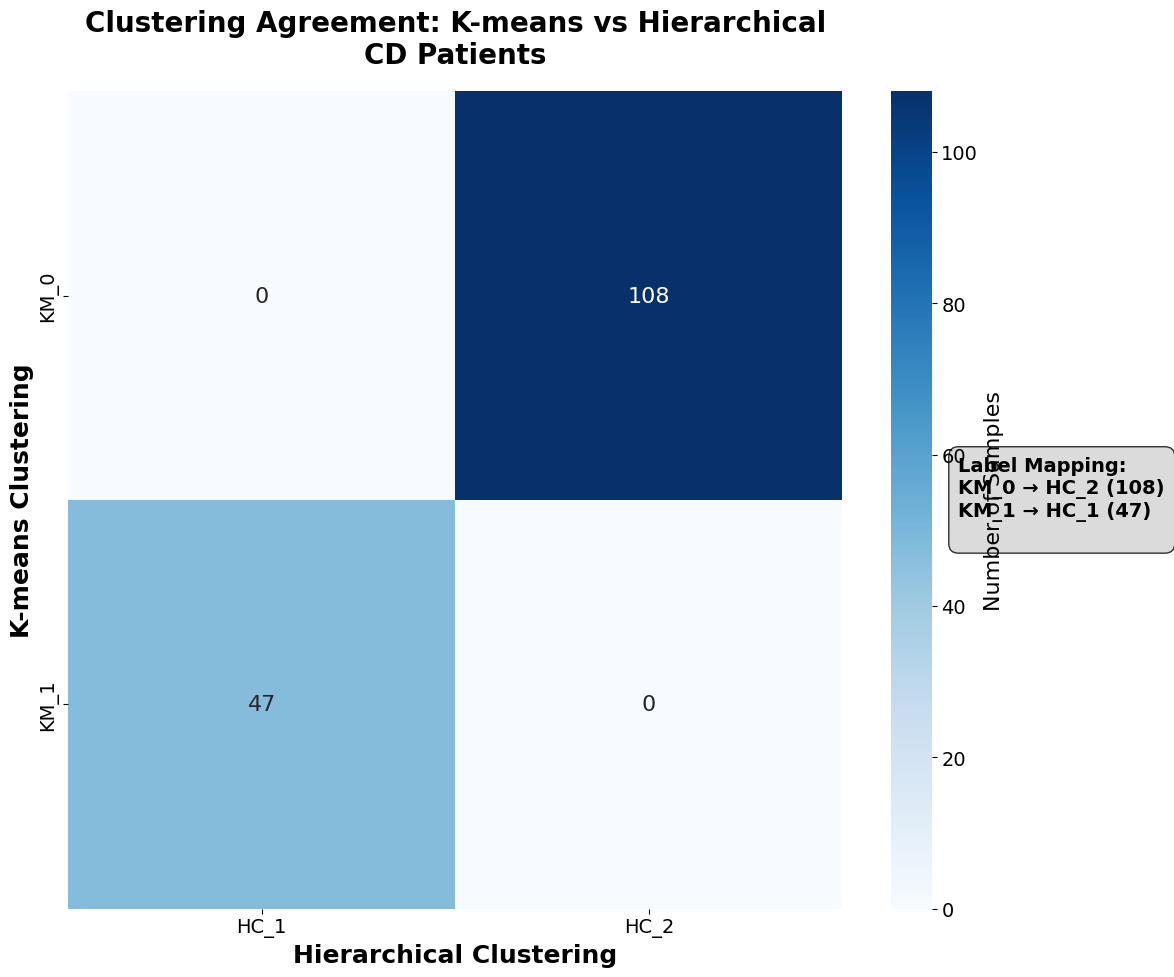

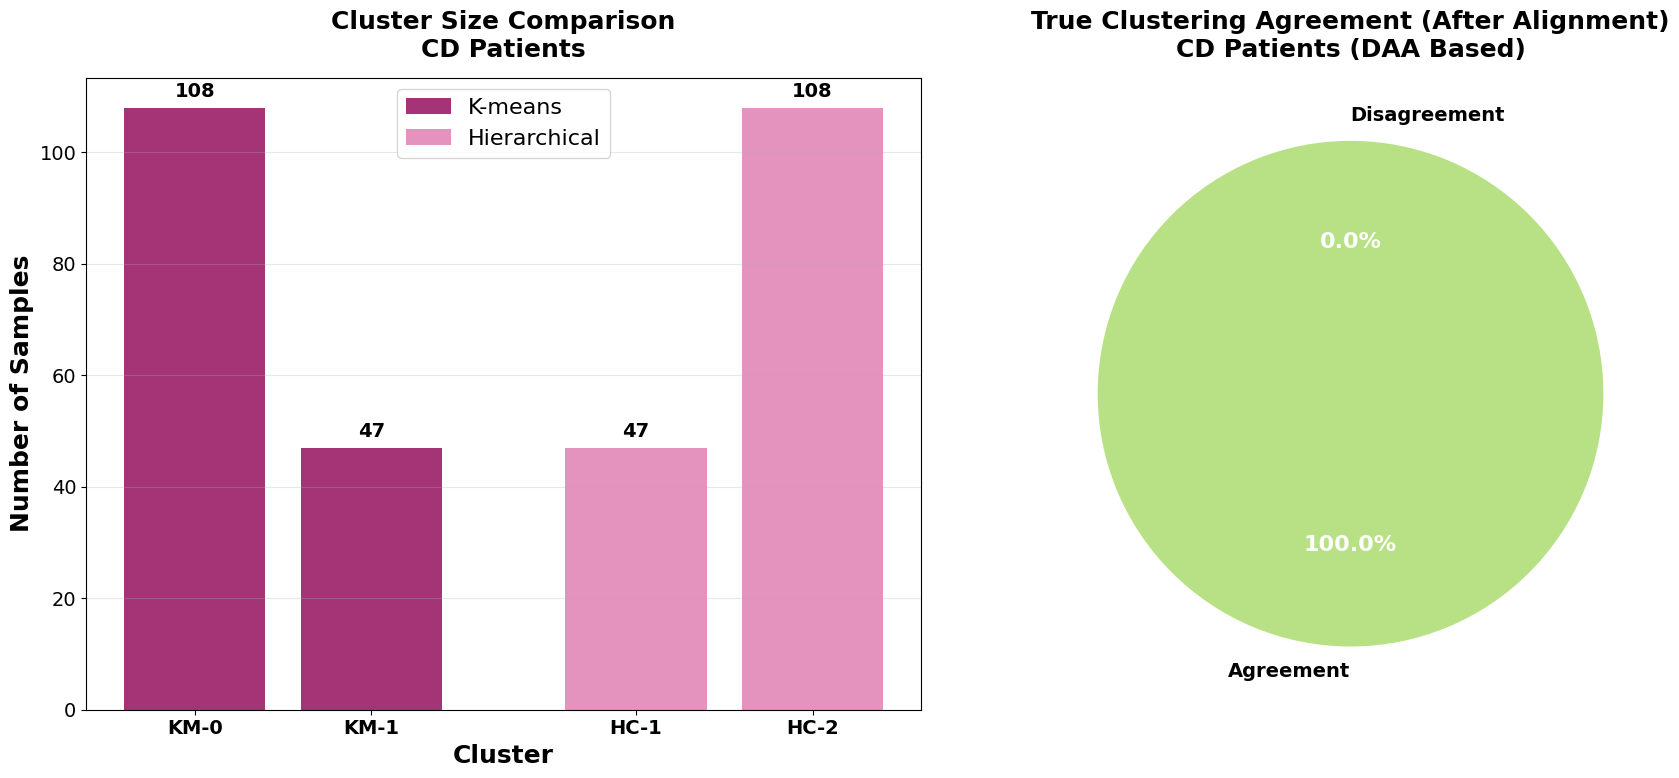

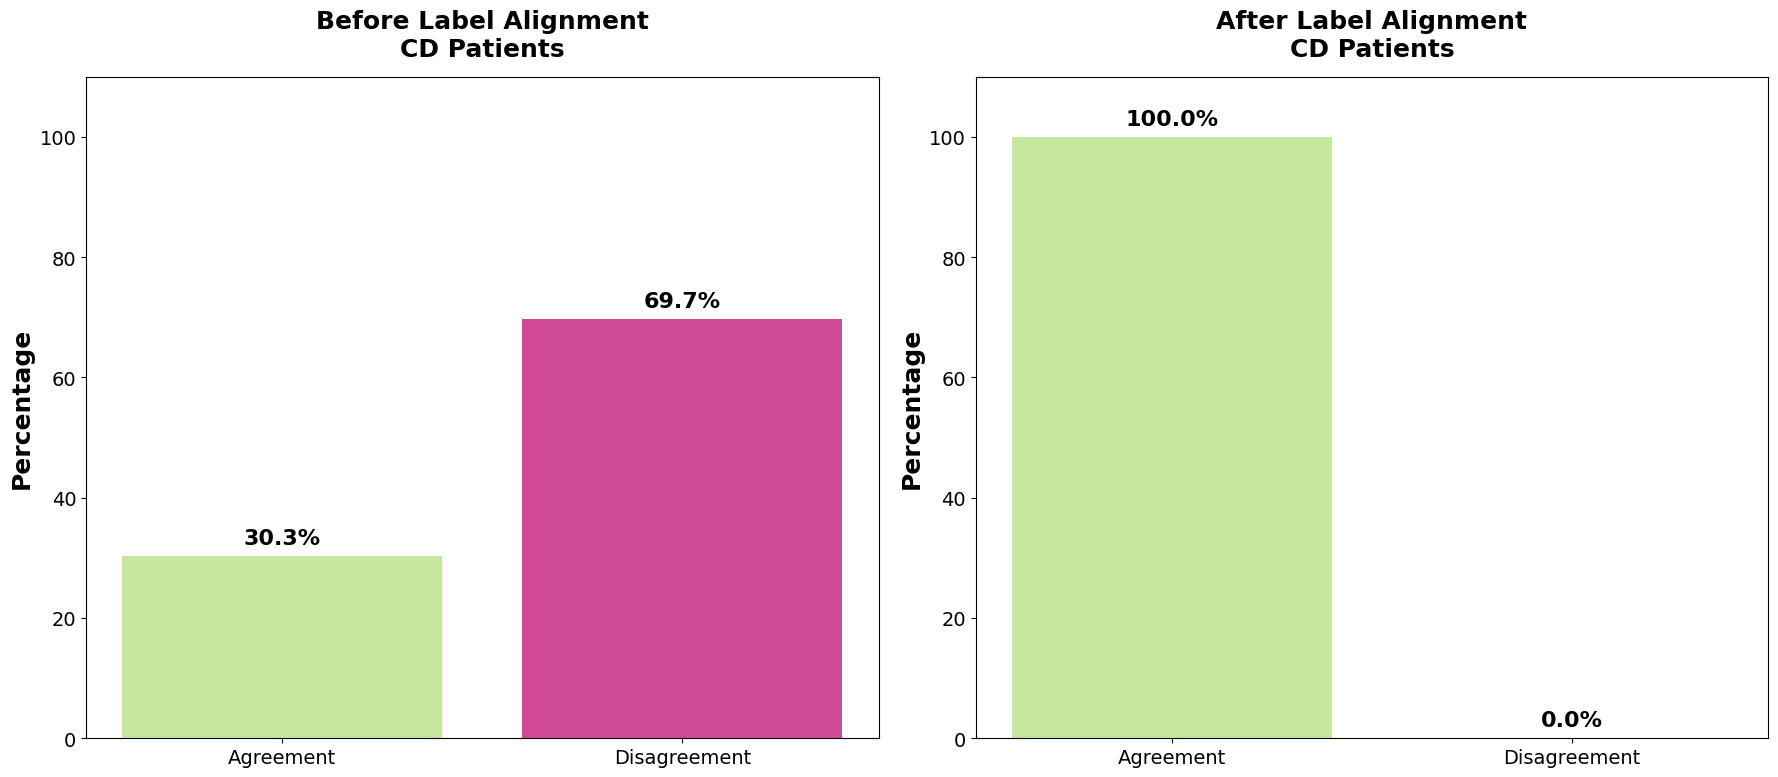


--------------------------------------------------
SAMPLE-LEVEL DISAGREEMENT ANALYSIS (AFTER ALIGNMENT)
--------------------------------------------------
Perfect agreement after label alignment! All samples assigned to corresponding clusters.

SUMMARY REPORT: CD CLUSTERING AGREEMENT
Samples analyzed: 155
K-means clusters: 2
Hierarchical clusters: 2

Label Mapping:
  K-means 0 → Hierarchical 2
  K-means 1 → Hierarchical 1

Agreement before alignment: 30.3%
Agreement after optimal alignment: 100.0%
TRUE agreement after alignment: 100.0%
Adjusted Rand Index: 1.0000
Normalized Mutual Information: 1.0000
Fowlkes-Mallows Index: 1.0000

Summary saved to: data/CD_clustering_agreement_summary_aligned.tsv
Starting clustering agreement analysis for UC patients...
Loaded K-means results: (96, 3296)
Loaded Hierarchical clustering results: (96, 3296)

CLUSTERING AGREEMENT ANALYSIS FOR UC PATIENTS
Analyzing agreement for 96 common samples

Original K-means clusters: [0, 1]
Hierarchical clusters: [1

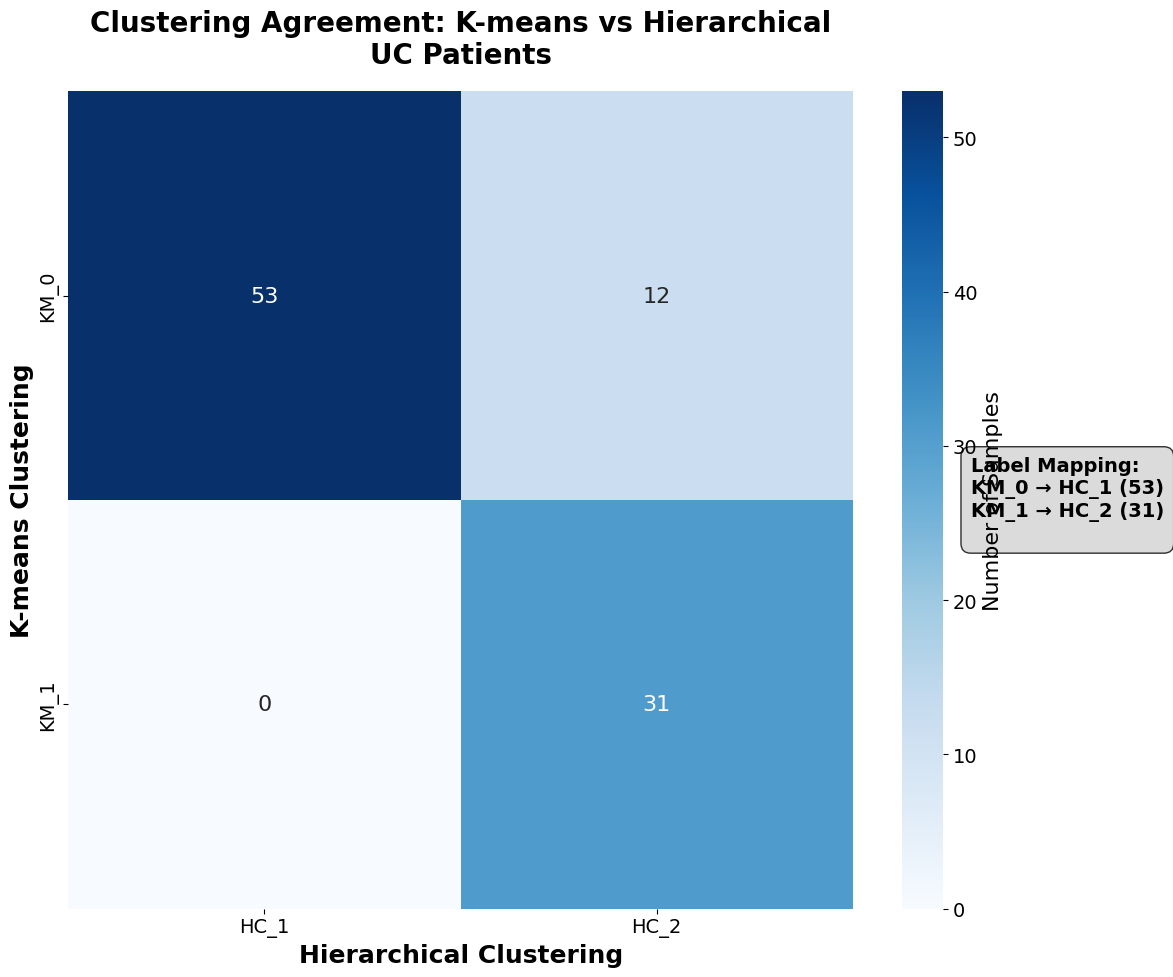

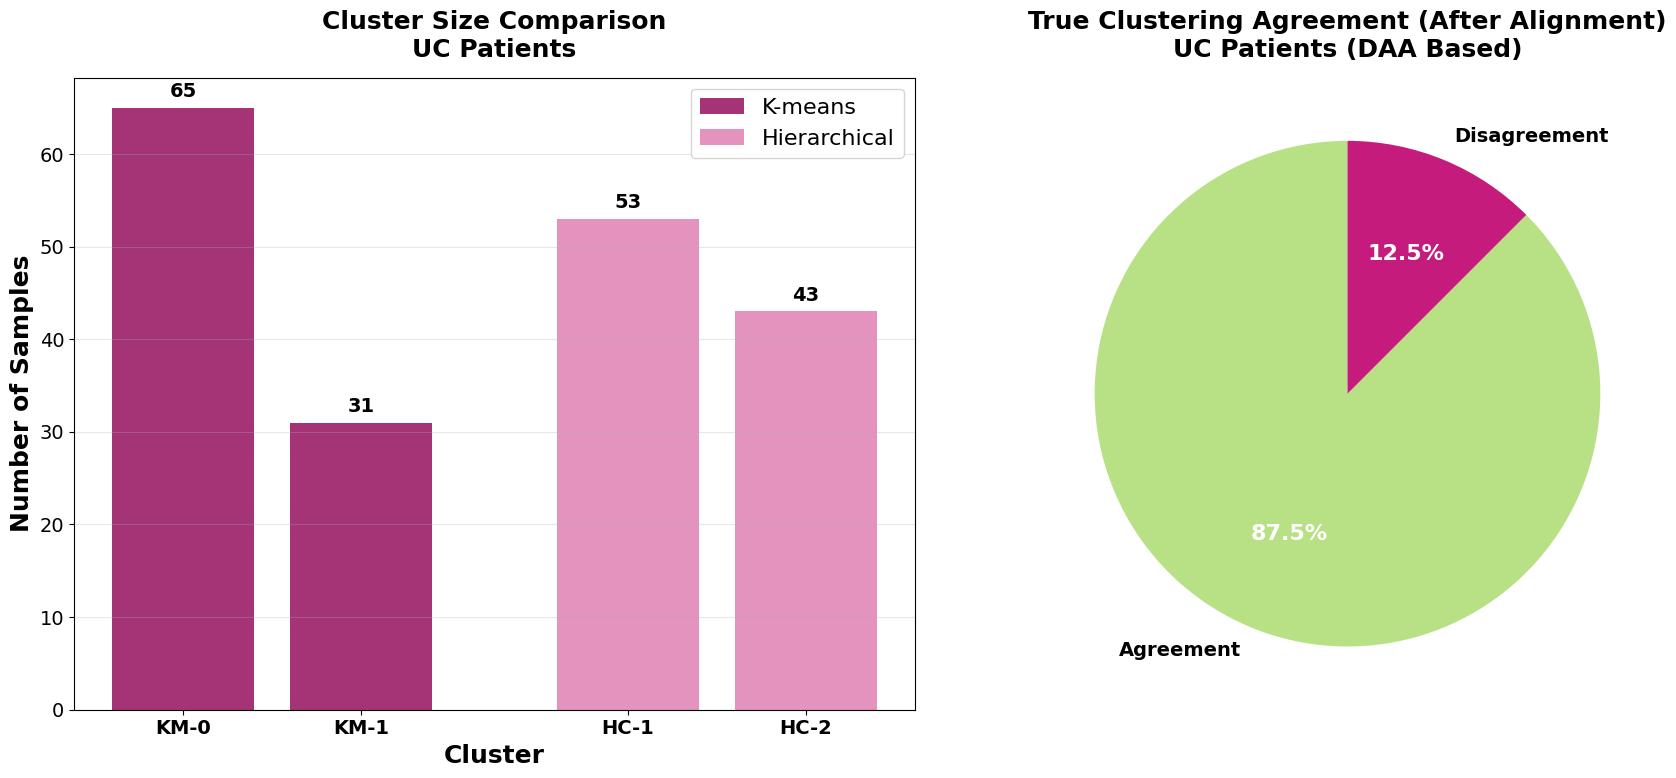

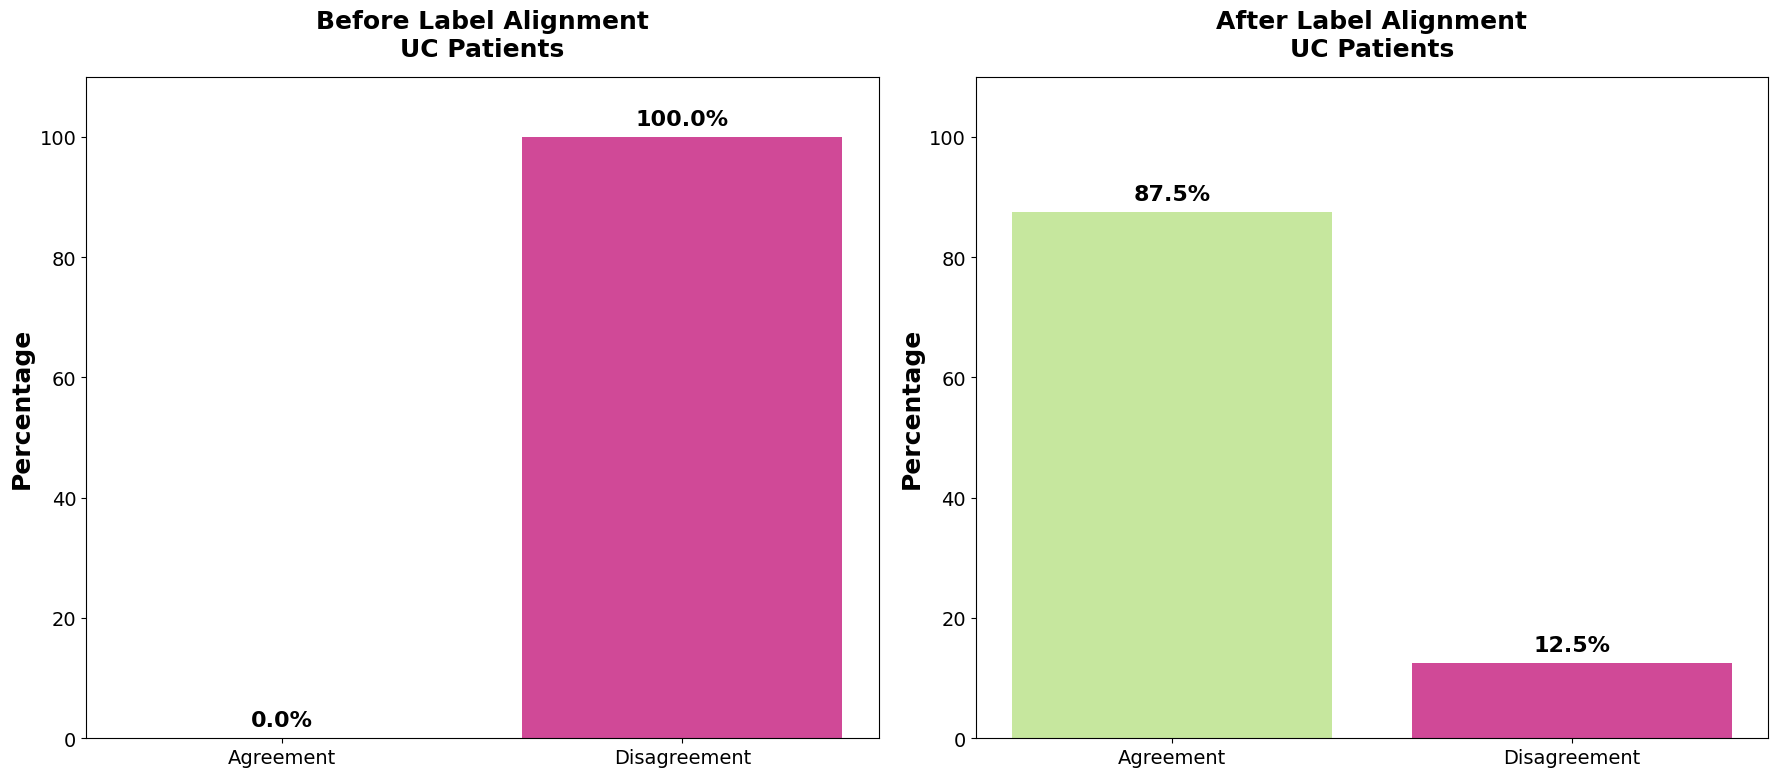


--------------------------------------------------
SAMPLE-LEVEL DISAGREEMENT ANALYSIS (AFTER ALIGNMENT)
--------------------------------------------------
Samples with TRUE disagreement: 12/96 (12.5%)

Samples with TRUE clustering disagreement:
  Sample  KMeans_Cluster  Hierarchical_Cluster  KMeans_Aligned
CSM5MCX3               0                     2               1
CSM7KOP8               0                     2               1
CSM7KOU9               0                     2               1
HSMA33MI               0                     2               1
MSM79H7G               0                     2               1
MSM79HDA               0                     2               1
MSMB4LZ4               0                     2               1
PSM6XBT3               0                     2               1
PSM7J12F               0                     2               1
PSM7J193               0                     2               1
PSM7J1AU               0                     2               

In [6]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
from sklearn.metrics import confusion_matrix, classification_report
import scipy.stats as stats
from matplotlib.patches import Patch
from scipy.optimize import linear_sum_assignment
from matplotlib.colors import ListedColormap
import matplotlib as mpl
warnings.filterwarnings('ignore')

CUSTOM_COLORS = ['#8e0152','#c51b7d','#de77ae','#f1b6da','#fde0ef','#e6f5d0','#b8e186','#7fbc41','#4d9221','#276419']

# Set global font sizes
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 20
})

def load_clustering_results(dataset_prefix='CD'):
    """Load clustering results from both methods"""
    
    # File paths based on your code structure
    kmeans_file = f'processing_data/{dataset_prefix}_kmeans_clustered_data_not_boruta_k2.tsv'
    hc_file = f'processing_data/{dataset_prefix}_hierarchical_clustered_data_not_boruta_k2.tsv'
    
    try:
        kmeans_df = pd.read_csv(kmeans_file, sep='\t')
        print(f"Loaded K-means results: {kmeans_df.shape}")
    except FileNotFoundError:
        print(f"Error: {kmeans_file} not found")
        return None, None
    
    try:
        hc_df = pd.read_csv(hc_file, sep='\t')
        print(f"Loaded Hierarchical clustering results: {hc_df.shape}")
    except FileNotFoundError:
        print(f"Error: {hc_file} not found")
        return None, None
    
    return kmeans_df, hc_df

def find_optimal_label_mapping(labels1, labels2):
    """Find optimal mapping between two sets of cluster labels using Hungarian algorithm"""
    
    # Get unique labels
    unique1 = sorted(np.unique(labels1))
    unique2 = sorted(np.unique(labels2))
    
    print(f"Debug - Unique labels in method 1: {unique1}")
    print(f"Debug - Unique labels in method 2: {unique2}")
    
    # Create confusion matrix - simple approach
    cm = np.zeros((len(unique1), len(unique2)))
    for i, l1 in enumerate(unique1):
        for j, l2 in enumerate(unique2):
            cm[i, j] = np.sum((labels1 == l1) & (labels2 == l2))
    
    print(f"Debug - Confusion matrix shape: {cm.shape}")
    print(f"Debug - Confusion matrix:\n{cm}")
    
    # Handle case where number of clusters differs
    if len(unique1) != len(unique2):
        # Pad the smaller dimension with zeros to make it square
        max_n = max(len(unique1), len(unique2))
        padded_cm = np.zeros((max_n, max_n))
        padded_cm[:len(unique1), :len(unique2)] = cm
        cm_for_assignment = padded_cm
    else:
        cm_for_assignment = cm
    
    # Hungarian algorithm to find optimal assignment
    # We want to maximize agreement, so using negative of confusion matrix
    row_ind, col_ind = linear_sum_assignment(-cm_for_assignment)
    
    print(f"Debug - Hungarian algorithm indices: rows={row_ind}, cols={col_ind}")
    
    # mapping dictionary
    mapping = {}
    for i, j in zip(row_ind, col_ind):
        if i < len(unique1) and j < len(unique2):
            mapping[unique1[i]] = unique2[j]
            print(f"Debug - Mapping {unique1[i]} → {unique2[j]} (count: {cm[i,j]})")
    
    # agreement score after optimal mapping
    mapped_labels1 = np.array([mapping.get(label, label) for label in labels1])
    agreement_score = np.sum(mapped_labels1 == labels2) / len(labels1)
    
    return mapping, agreement_score, cm

def align_cluster_labels(kmeans_labels, hc_labels):
    """Align cluster labels to maximize agreement"""
    # optimal mapping from kmeans to hierarchical
    mapping, agreement_score, cm = find_optimal_label_mapping(kmeans_labels, hc_labels)
    # Apply mapping to kmeans labels
    aligned_kmeans = np.array([mapping.get(label, label) for label in kmeans_labels])
    return aligned_kmeans, mapping, agreement_score

def analyze_clustering_agreement(kmeans_df, hc_df, dataset_prefix='CD'):
    """Comprehensive agreement analysis between clustering methods with label alignment"""
    
    print(f"\n{'='*60}")
    print(f"CLUSTERING AGREEMENT ANALYSIS FOR {dataset_prefix} PATIENTS")
    print(f"{'='*60}")
    
    # Ensures we're comparing the same samples
    common_samples = set(kmeans_df['Sample']).intersection(set(hc_df['Sample']))
    
    if len(common_samples) == 0:
        print("No common samples found between clustering results!")
        return None
    
    print(f"Analyzing agreement for {len(common_samples)} common samples")
    
    # Filter to common samples and sort by Sample ID for alignment
    kmeans_common = kmeans_df[kmeans_df['Sample'].isin(common_samples)].sort_values('Sample').reset_index(drop=True)
    hc_common = hc_df[hc_df['Sample'].isin(common_samples)].sort_values('Sample').reset_index(drop=True)
    
    # Extract cluster labels
    kmeans_labels_original = kmeans_common['KMeans_Cluster'].values
    hc_labels = hc_common['Hierarchical_Cluster'].values
    sample_ids = kmeans_common['Sample'].values
    
    # Basic cluster information
    print(f"\nOriginal K-means clusters: {sorted(np.unique(kmeans_labels_original))}")
    print(f"Hierarchical clusters: {sorted(np.unique(hc_labels))}")
    print(f"Number of K-means clusters: {len(np.unique(kmeans_labels_original))}")
    print(f"Number of Hierarchical clusters: {len(np.unique(hc_labels))}")
    
    # # Additional debugging for UC with 3 clusters
    # if dataset_prefix == 'UC' and len(np.unique(hc_labels)) < 3:
    #     print("\nDEBUG: Expected 3 hierarchical clusters for UC but found fewer.")
    #     print("Checking original data before filtering...")
    #     hc_all_clusters = sorted(hc_df['Hierarchical_Cluster'].unique())
    #     print(f"All hierarchical clusters in original file: {hc_all_clusters}")
    #     for cluster in hc_all_clusters:
    #         n_samples = len(hc_df[hc_df['Hierarchical_Cluster'] == cluster])
    #         n_common = len(hc_df[(hc_df['Hierarchical_Cluster'] == cluster) & (hc_df['Sample'].isin(common_samples))])
    #         print(f"  Cluster {cluster}: {n_samples} total samples, {n_common} in common set")
    
    # --- Label Alignment ---
    print(f"\n{'-'*50}")
    print("CLUSTER LABEL ALIGNMENT")
    print(f"{'-'*50}")
    
    kmeans_labels, label_mapping, alignment_score = align_cluster_labels(kmeans_labels_original, hc_labels)
    
    print(f"Optimal label mapping (K-means → Hierarchical):")
    for k, v in label_mapping.items():
        n_samples = np.sum(kmeans_labels_original == k)
        print(f"  K-means Cluster {k} → Hierarchical Cluster {v} ({n_samples} samples)")
    
    # Calculate agreement before alignment
    before_alignment_agreement = np.sum(kmeans_labels_original == hc_labels) / len(kmeans_labels_original)
    print(f"\nAgreement before alignment: {before_alignment_agreement*100:.1f}%")
    print(f"Agreement after optimal alignment: {alignment_score*100:.1f}%")
    
    # --- Agreement Metrics (these don't change with label alignment) ---
    print(f"\n{'-'*50}")
    print("CLUSTERING AGREEMENT METRICS")
    print(f"{'-'*50}")
    
    # These metrics are invariant to label permutations
    ari = adjusted_rand_score(kmeans_labels_original, hc_labels)
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"  Interpretation: {interpret_ari(ari)}")
    
    nmi = normalized_mutual_info_score(kmeans_labels_original, hc_labels)
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
    print(f"  Interpretation: {interpret_nmi(nmi)}")
    
    fmi = fowlkes_mallows_score(kmeans_labels_original, hc_labels)
    print(f"Fowlkes-Mallows Index (FMI): {fmi:.4f}")
    print(f"  Interpretation: {interpret_fmi(fmi)}")
    
    # --- Confusion Matrix Analysis ---
    print(f"\n{'-'*50}")
    print("CONFUSION MATRIX ANALYSIS")
    print(f"{'-'*50}")
    
    # Create confusion matrix with original labels
    kmeans_clusters = sorted(np.unique(kmeans_labels_original))
    hc_clusters = sorted(np.unique(hc_labels))
    
    # Create confusion matrix properly handling different label sets
    all_labels = sorted(set(kmeans_clusters) | set(hc_clusters))
    cm_full = confusion_matrix(kmeans_labels_original, hc_labels, labels=all_labels)
    
    # Extract the relevant part of the confusion matrix
    km_indices = [all_labels.index(k) for k in kmeans_clusters]
    hc_indices = [all_labels.index(h) for h in hc_clusters]
    cm = cm_full[np.ix_(km_indices, hc_indices)]
    
    print("Confusion Matrix (K-means vs Hierarchical):")
    print("Rows = K-means clusters, Columns = Hierarchical clusters")
    
    # Create DataFrame for confusion matrix
    cm_df = pd.DataFrame(cm, 
                        index=[f'KM_{i}' for i in kmeans_clusters],
                        columns=[f'HC_{i}' for i in hc_clusters])
    print(cm_df)
    
    # Additional analysis for different numbers of clusters
    if len(kmeans_clusters) != len(hc_clusters):
        print(f"\n{'-'*50}")
        print("CLUSTER SPLIT ANALYSIS")
        print(f"{'-'*50}")
        print(f"K-means has {len(kmeans_clusters)} clusters, Hierarchical has {len(hc_clusters)} clusters")
        
        if len(kmeans_clusters) < len(hc_clusters):
            print("\nHow K-means clusters split across Hierarchical clusters:")
            for i, km_cluster in enumerate(kmeans_clusters):
                row_data = cm[i, :]
                total = np.sum(row_data)
                print(f"\nK-means Cluster {km_cluster} ({total} samples) splits into:")
                for j, hc_cluster in enumerate(hc_clusters):
                    count = row_data[j]
                    if count > 0:
                        print(f"  → HC Cluster {hc_cluster}: {count} samples ({count/total*100:.1f}%)")
        else:
            print("\nHow Hierarchical clusters map to K-means clusters:")
            for j, hc_cluster in enumerate(hc_clusters):
                col_data = cm[:, j]
                total = np.sum(col_data)
                print(f"\nHierarchical Cluster {hc_cluster} ({total} samples) maps to:")
                for i, km_cluster in enumerate(kmeans_clusters):
                    count = col_data[i]
                    if count > 0:
                        print(f"  → KM Cluster {km_cluster}: {count} samples ({count/total*100:.1f}%)")
    
    # --- Visualizations ---
    create_agreement_visualizations(kmeans_labels_original, hc_labels, kmeans_labels, 
                                  sample_ids, kmeans_clusters, hc_clusters, 
                                  cm_df, label_mapping, dataset_prefix)
    
    # --- Sample-level Analysis (AFTER ALIGNMENT) ---
    print(f"\n{'-'*50}")
    print("SAMPLE-LEVEL DISAGREEMENT ANALYSIS (AFTER ALIGNMENT)")
    print(f"{'-'*50}")
    
    # Identify samples with TRUE disagreement after alignment
    true_disagreement_mask = kmeans_labels != hc_labels
    disagreeing_samples = sample_ids[true_disagreement_mask]
    
    if len(disagreeing_samples) > 0:
        print(f"Samples with TRUE disagreement: {len(disagreeing_samples)}/{len(sample_ids)} ({len(disagreeing_samples)/len(sample_ids)*100:.1f}%)")
        
        # Create disagreement analysis DataFrame
        disagreement_df = pd.DataFrame({
            'Sample': sample_ids[true_disagreement_mask],
            'KMeans_Cluster': kmeans_labels_original[true_disagreement_mask],
            'Hierarchical_Cluster': hc_labels[true_disagreement_mask],
            'KMeans_Aligned': kmeans_labels[true_disagreement_mask]
        })
        
        print("\nSamples with TRUE clustering disagreement:")
        print(disagreement_df.to_string(index=False))
        
        # Save disagreement analysis
        disagreement_df.to_csv(f'data/{dataset_prefix}_clustering_true_disagreements.tsv', sep='\t', index=False)
        print(f"\nTrue disagreement analysis saved to: data/{dataset_prefix}_clustering_true_disagreements.tsv")
    else:
        print("Perfect agreement after label alignment! All samples assigned to corresponding clusters.")
    
    # --- Summary Results ---
    before_alignment_percentage = np.sum(kmeans_labels_original == hc_labels) / len(kmeans_labels_original) * 100
    
    results_summary = {
        'dataset': dataset_prefix,
        'n_samples': len(sample_ids),
        'n_kmeans_clusters': len(np.unique(kmeans_labels_original)),
        'n_hc_clusters': len(np.unique(hc_labels)),
        'adjusted_rand_index': ari,
        'normalized_mutual_info': nmi,
        'fowlkes_mallows_index': fmi,
        'label_mapping': label_mapping,
        'agreement_before_alignment': before_alignment_percentage,
        'alignment_agreement_percentage': alignment_score * 100,
        'true_agreement_percentage': (len(sample_ids) - len(disagreeing_samples)) / len(sample_ids) * 100,
        'true_disagreeing_samples': len(disagreeing_samples),
        'confusion_matrix': cm_df
    }
    
    return results_summary

def interpret_ari(ari):
    """Interpret Adjusted Rand Index values"""
    if ari >= 0.9:
        return "Excellent agreement"
    elif ari >= 0.7:
        return "Good agreement"
    elif ari >= 0.5:
        return "Moderate agreement"
    elif ari >= 0.3:
        return "Fair agreement"
    elif ari >= 0.1:
        return "Poor agreement"
    else:
        return "Very poor agreement"

def interpret_nmi(nmi):
    """Interpret Normalized Mutual Information values"""
    if nmi >= 0.9:
        return "Excellent information sharing"
    elif nmi >= 0.7:
        return "Good information sharing"
    elif nmi >= 0.5:
        return "Moderate information sharing"
    elif nmi >= 0.3:
        return "Fair information sharing"
    else:
        return "Poor information sharing"

def interpret_fmi(fmi):
    """Interpret Fowlkes-Mallows Index values"""
    if fmi >= 0.9:
        return "Excellent similarity"
    elif fmi >= 0.7:
        return "Good similarity"
    elif fmi >= 0.5:
        return "Moderate similarity"
    elif fmi >= 0.3:
        return "Fair similarity"
    else:
        return "Poor similarity"

def create_agreement_visualizations(kmeans_labels_original, hc_labels, kmeans_labels_aligned,
                                  sample_ids, kmeans_clusters, hc_clusters, 
                                  cm_df, label_mapping, dataset_prefix):
    """Create comprehensive visualizations for clustering agreement with custom colors and larger fonts"""
    
    # custom colormap for heatmap
    custom_cmap = ListedColormap(CUSTOM_COLORS)
    
    # 1. Confusion Matrix Heatmap
    # For non-square matrices, adjust figure size
    if len(kmeans_clusters) != len(hc_clusters):
        fig_width = 10 + len(hc_clusters) * 1.5
        fig_height = 8 + len(kmeans_clusters) * 1.5
        plt.figure(figsize=(fig_width, fig_height))
    else:
        plt.figure(figsize=(12, 10))
    
    # Using custom colormap with blues theme but enhanced colors
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', 
                cbar_kws={'label': 'Number of Samples'},
                annot_kws={'size': 16})
    plt.title(f'Clustering Agreement: K-means vs Hierarchical\n{dataset_prefix} Patients', 
              fontsize=20, pad=20, fontweight='bold')
    plt.xlabel('Hierarchical Clustering', fontsize=18, fontweight='bold')
    plt.ylabel('K-means Clustering', fontsize=18, fontweight='bold')
    mapping_text = "Label Mapping:\n"
    for k, v in label_mapping.items():
        n_samples = int(cm_df.loc[f'KM_{k}', f'HC_{v}']) if f'HC_{v}' in cm_df.columns else 0
        mapping_text += f"KM_{k} → HC_{v} ({n_samples})\n"
    plt.text(1.15, 0.5, mapping_text, transform=plt.gca().transAxes,
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8),
             verticalalignment='center', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Agreement Pattern Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Cluster size comparison with custom colors
    kmeans_counts = pd.Series(kmeans_labels_original).value_counts().sort_index()
    hc_counts = pd.Series(hc_labels).value_counts().sort_index()
    
    # Get all unique cluster numbers from both methods
    all_km_clusters = sorted(np.unique(kmeans_labels_original))
    all_hc_clusters = sorted(np.unique(hc_labels))
    
    # Determine x-axis positions
    km_x_pos = np.arange(len(all_km_clusters))
    hc_x_pos = np.arange(len(all_hc_clusters)) + len(all_km_clusters) + 0.5
    
    # Plot K-means clusters with custom colors
    km_bars = ax1.bar(km_x_pos, [kmeans_counts[c] for c in all_km_clusters], 
                      width=0.8, label='K-means', alpha=0.8, color=CUSTOM_COLORS[0])
    
    # Plot Hierarchical clusters with custom colors
    hc_bars = ax1.bar(hc_x_pos, [hc_counts[c] for c in all_hc_clusters], 
                      width=0.8, label='Hierarchical', alpha=0.8, color=CUSTOM_COLORS[2])
    
    # Add value labels on bars with larger font
    for bars, clusters in [(km_bars, all_km_clusters), (hc_bars, all_hc_clusters)]:
        for bar, cluster in zip(bars, clusters):
            height = bar.get_height()
            ax1.annotate(f'{int(height)}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 5),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    # Set x-axis labels
    all_x_pos = list(km_x_pos) + list(hc_x_pos)
    all_labels = [f'KM-{c}' for c in all_km_clusters] + [f'HC-{c}' for c in all_hc_clusters]
    ax1.set_xticks(all_x_pos)
    ax1.set_xticklabels(all_labels, fontsize=14, fontweight='bold')
    
    ax1.set_xlabel('Cluster', fontsize=18, fontweight='bold')
    ax1.set_ylabel('Number of Samples', fontsize=18, fontweight='bold')
    ax1.set_title(f'Cluster Size Comparison\n{dataset_prefix} Patients', fontsize=18, fontweight='bold', pad=15)
    ax1.legend(fontsize=16)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.tick_params(axis='y', labelsize=14)
    
    # Agreement/Disagreement pie chart with custom colors
    true_agreement_count = np.sum(kmeans_labels_aligned == hc_labels)
    true_disagreement_count = len(kmeans_labels_aligned) - true_agreement_count
    
    pie_colors = [CUSTOM_COLORS[6], CUSTOM_COLORS[1]]  # Green and pink from palette
    wedges, texts, autotexts = ax2.pie([true_agreement_count, true_disagreement_count], 
                                      labels=['Agreement', 'Disagreement'],
                                      colors=pie_colors,
                                      autopct='%1.1f%%',
                                      startangle=90,
                                      textprops={'fontsize': 14, 'fontweight': 'bold'})
    
    # Make percentage text larger and bold
    for autotext in autotexts:
        autotext.set_fontsize(16)
        autotext.set_fontweight('bold')
        autotext.set_color('white')
    
    ax2.set_title(f'True Clustering Agreement (After Alignment)\n{dataset_prefix} Patients (DAA Based)',
                  fontsize=18, fontweight='bold', pad=15)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Before/After alignment comparison with custom colors
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Before alignment
    before_agreement = np.sum(kmeans_labels_original == hc_labels) / len(kmeans_labels_original) * 100
    bars1 = ax1.bar(['Agreement', 'Disagreement'], 
                    [before_agreement, 100-before_agreement],
                    color=[CUSTOM_COLORS[6], CUSTOM_COLORS[1]], alpha=0.8)
    ax1.set_ylabel('Percentage', fontsize=18, fontweight='bold')
    ax1.set_title(f'Before Label Alignment\n{dataset_prefix} Patients', fontsize=18, fontweight='bold', pad=15)
    ax1.set_ylim(0, 110)
    ax1.tick_params(axis='both', labelsize=14)
    
    for i, (bar, v) in enumerate(zip(bars1, [before_agreement, 100-before_agreement])):
        ax1.text(bar.get_x() + bar.get_width()/2, v + 2, f'{v:.1f}%', 
                ha='center', fontsize=16, fontweight='bold')
    
    # After alignment
    after_agreement = np.sum(kmeans_labels_aligned == hc_labels) / len(kmeans_labels_aligned) * 100
    bars2 = ax2.bar(['Agreement', 'Disagreement'], 
                    [after_agreement, 100-after_agreement],
                    color=[CUSTOM_COLORS[6], CUSTOM_COLORS[1]], alpha=0.8)
    ax2.set_ylabel('Percentage', fontsize=18, fontweight='bold')
    ax2.set_title(f'After Label Alignment\n{dataset_prefix} Patients', fontsize=18, fontweight='bold', pad=15)
    ax2.set_ylim(0, 110)
    ax2.tick_params(axis='both', labelsize=14)
    
    for i, (bar, v) in enumerate(zip(bars2, [after_agreement, 100-after_agreement])):
        ax2.text(bar.get_x() + bar.get_width()/2, v + 2, f'{v:.1f}%', 
                ha='center', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def run_comprehensive_analysis(dataset_prefix='CD'):
    """Run the complete clustering agreement analysis with label alignment"""
    
    print(f"Starting clustering agreement analysis for {dataset_prefix} patients...")
    
    # Load data
    kmeans_df, hc_df = load_clustering_results(dataset_prefix)
    
    if kmeans_df is None or hc_df is None:
        print("Could not load clustering results. Please check file paths.")
        return None
    
    # Run agreement analysis
    results = analyze_clustering_agreement(kmeans_df, hc_df, dataset_prefix)
    
    if results is None:
        print("Agreement analysis failed.")
        return None
    
    # Create summary report
    print(f"\n{'='*60}")
    print(f"SUMMARY REPORT: {dataset_prefix} CLUSTERING AGREEMENT")
    print(f"{'='*60}")
    print(f"Samples analyzed: {results['n_samples']}")
    print(f"K-means clusters: {results['n_kmeans_clusters']}")
    print(f"Hierarchical clusters: {results['n_hc_clusters']}")
    print(f"\nLabel Mapping:")
    for k, v in results['label_mapping'].items():
        print(f"  K-means {k} → Hierarchical {v}")
    
    if results['n_kmeans_clusters'] != results['n_hc_clusters']:
        print(f"\nNote: K-means has {results['n_kmeans_clusters']} clusters while Hierarchical has {results['n_hc_clusters']} clusters")
        print("The mapping shows the best alignment, but perfect 1:1 correspondence is not possible.")
    
    print(f"\nAgreement before alignment: {results['agreement_before_alignment']:.1f}%")
    print(f"Agreement after optimal alignment: {results['alignment_agreement_percentage']:.1f}%")
    print(f"TRUE agreement after alignment: {results['true_agreement_percentage']:.1f}%")
    print(f"Adjusted Rand Index: {results['adjusted_rand_index']:.4f}")
    print(f"Normalized Mutual Information: {results['normalized_mutual_info']:.4f}")
    print(f"Fowlkes-Mallows Index: {results['fowlkes_mallows_index']:.4f}")
    
    # Save summary to file
    summary_df = pd.DataFrame([{
        'Dataset': results['dataset'],
        'N_Samples': results['n_samples'],
        'N_KMeans_Clusters': results['n_kmeans_clusters'],
        'N_HC_Clusters': results['n_hc_clusters'],
        'Agreement_Before_Alignment': results['agreement_before_alignment'],
        'Agreement_After_Optimal_Alignment': results['alignment_agreement_percentage'],
        'True_Agreement_After_Alignment': results['true_agreement_percentage'],
        'Adjusted_Rand_Index': results['adjusted_rand_index'],
        'Normalized_Mutual_Info': results['normalized_mutual_info'],
        'Fowlkes_Mallows_Index': results['fowlkes_mallows_index'],
        'True_Disagreeing_Samples': results['true_disagreeing_samples']
    }])
    
    summary_df.to_csv(f'data/{dataset_prefix}_clustering_agreement_summary_aligned.tsv', sep='\t', index=False)
    print(f"\nSummary saved to: data/{dataset_prefix}_clustering_agreement_summary_aligned.tsv")
    
    return results

if __name__ == "__main__":
    # Run analysis for CD and UC patients
    cd_results = run_comprehensive_analysis('CD')
    uc_results = run_comprehensive_analysis('UC')

# Boruta Based

Starting clustering agreement analysis for CD patients (Boruta features)...
Loaded K-means results: (155, 616)
Loaded Hierarchical clustering results: (155, 616)

CLUSTERING AGREEMENT ANALYSIS FOR CD PATIENTS (BORUTA)
Analyzing agreement for 155 common samples

Original K-means clusters: [0, 1]
Hierarchical clusters: [1, 2]
Number of K-means clusters: 2
Number of Hierarchical clusters: 2

--------------------------------------------------
CLUSTER LABEL ALIGNMENT
--------------------------------------------------
Debug - Unique labels in method 1: [0, 1]
Debug - Unique labels in method 2: [1, 2]
Debug - Confusion matrix shape: (2, 2)
Debug - Confusion matrix:
[[  0. 108.]
 [ 47.   0.]]
Debug - Hungarian algorithm indices: rows=[0 1], cols=[1 0]
Debug - Mapping 0 → 2 (count: 108.0)
Debug - Mapping 1 → 1 (count: 47.0)
Optimal label mapping (K-means → Hierarchical):
  K-means Cluster 0 → Hierarchical Cluster 2 (108 samples)
  K-means Cluster 1 → Hierarchical Cluster 1 (47 samples)

Agreeme

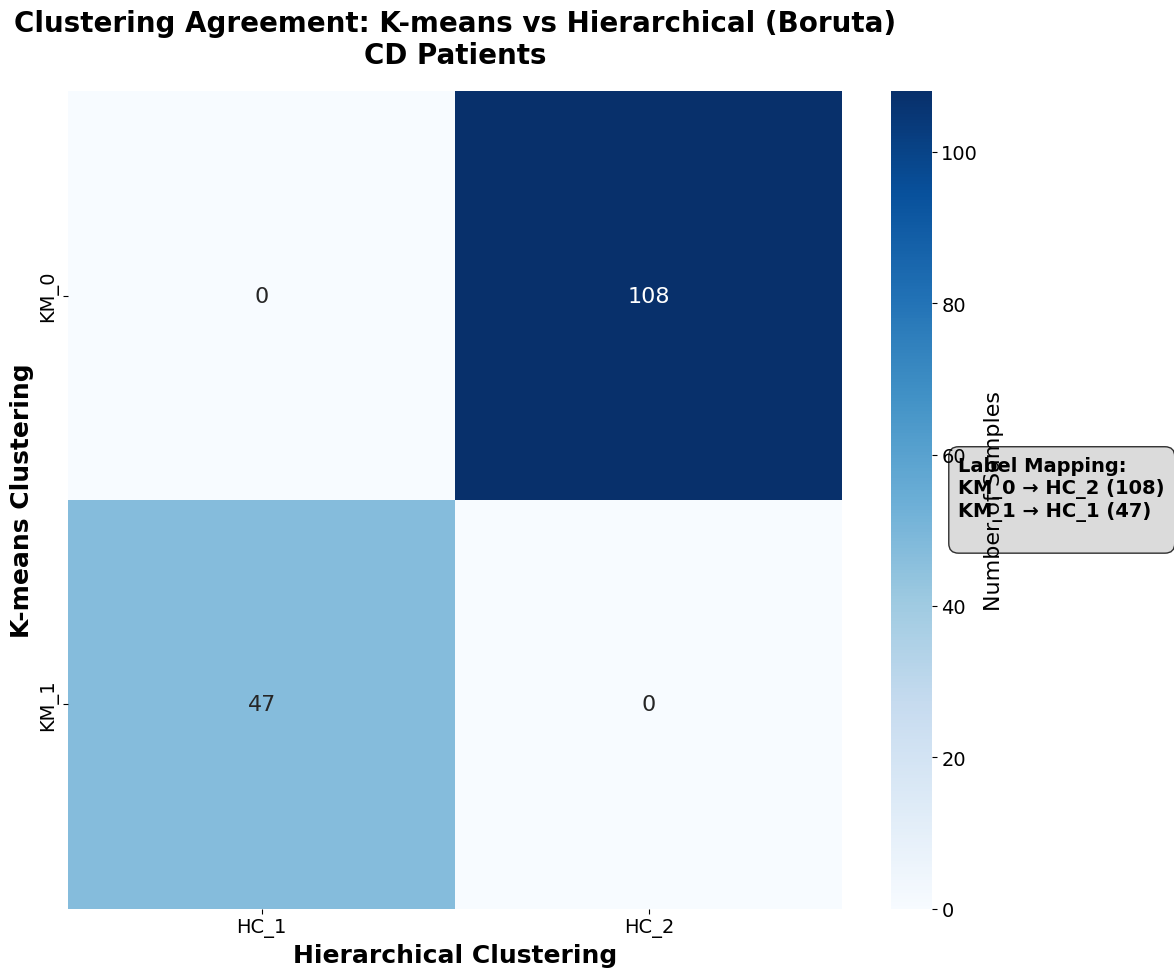

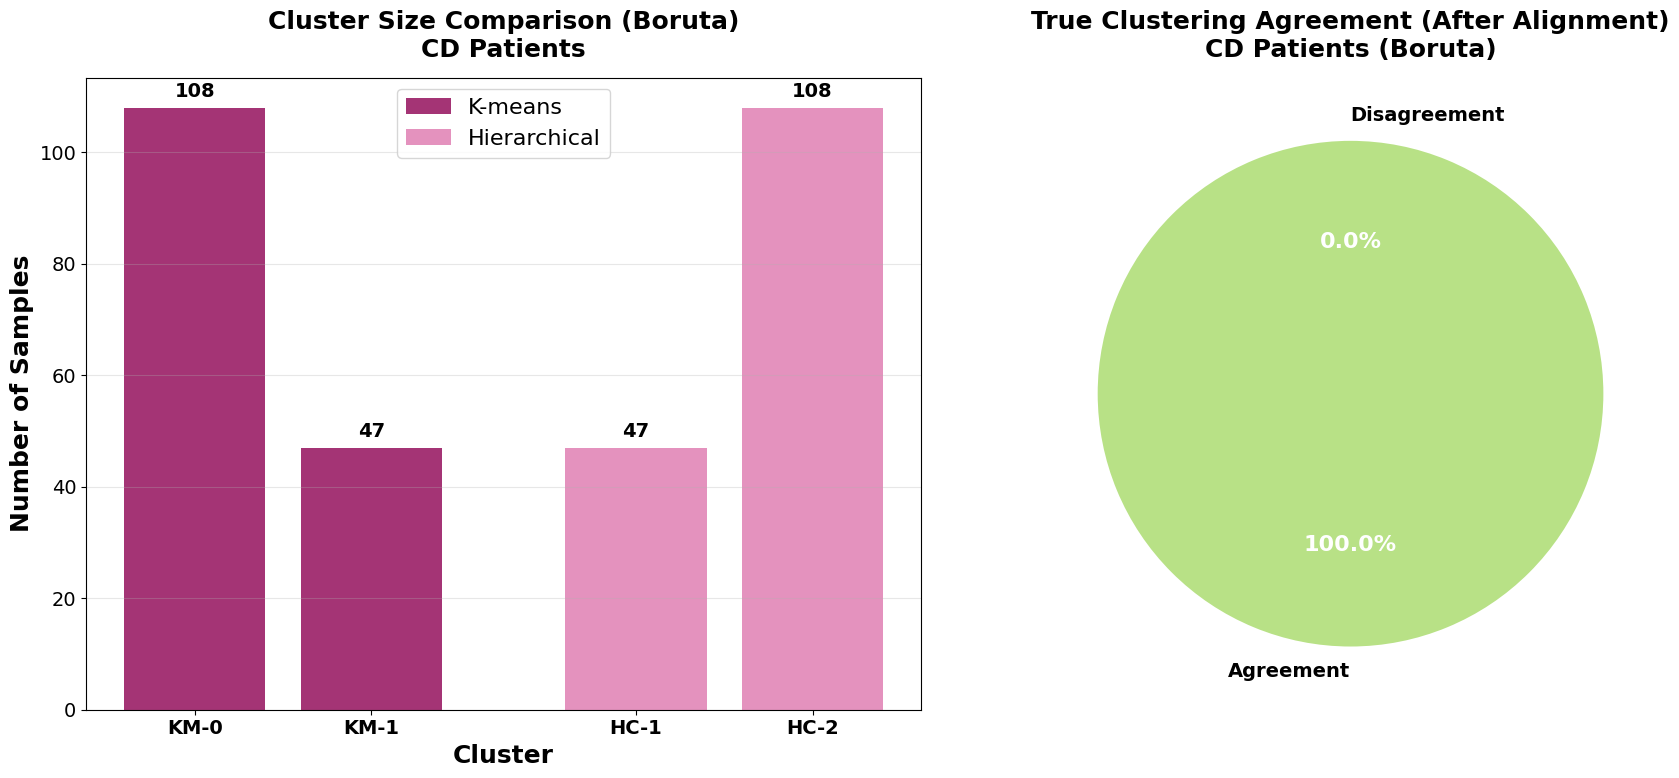

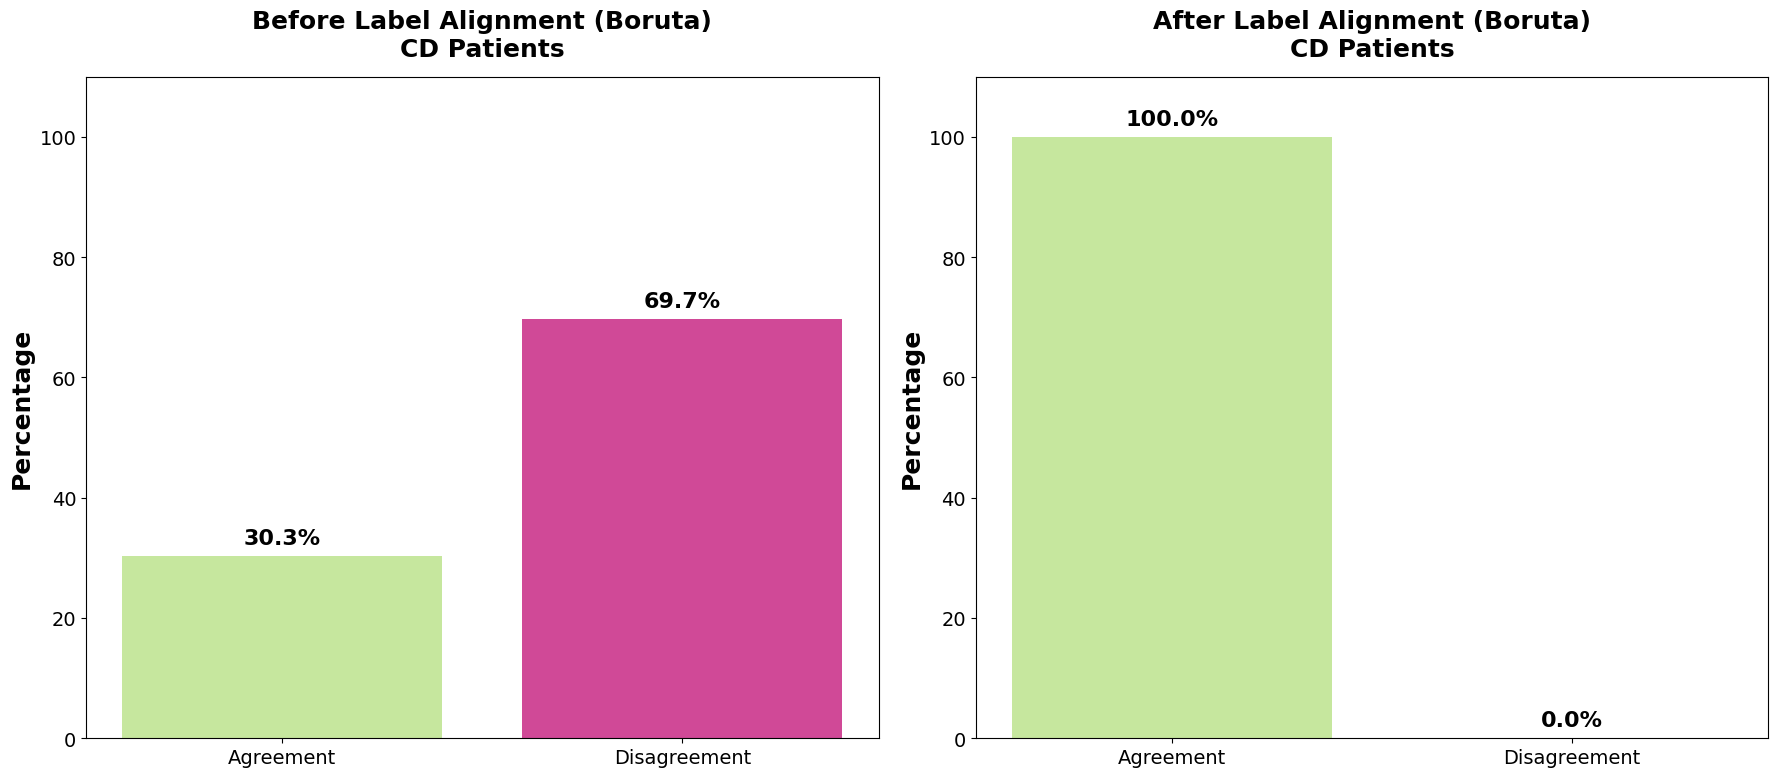


--------------------------------------------------
SAMPLE-LEVEL DISAGREEMENT ANALYSIS (AFTER ALIGNMENT)
--------------------------------------------------
Perfect agreement after label alignment! All samples assigned to corresponding clusters.

SUMMARY REPORT: CD CLUSTERING AGREEMENT (BORUTA)
Samples analyzed: 155
K-means clusters: 2
Hierarchical clusters: 2

Label Mapping:
  K-means 0 → Hierarchical 2
  K-means 1 → Hierarchical 1

Agreement before alignment: 30.3%
Agreement after optimal alignment: 100.0%
TRUE agreement after alignment: 100.0%
Adjusted Rand Index: 1.0000
Normalized Mutual Information: 1.0000
Fowlkes-Mallows Index: 1.0000

Summary saved to: boruta_data/CD_clustering_agreement_summary_aligned.tsv
Starting clustering agreement analysis for UC patients (Boruta features)...
Loaded K-means results: (96, 616)
Loaded Hierarchical clustering results: (96, 616)

CLUSTERING AGREEMENT ANALYSIS FOR UC PATIENTS (BORUTA)
Analyzing agreement for 96 common samples

Original K-means c

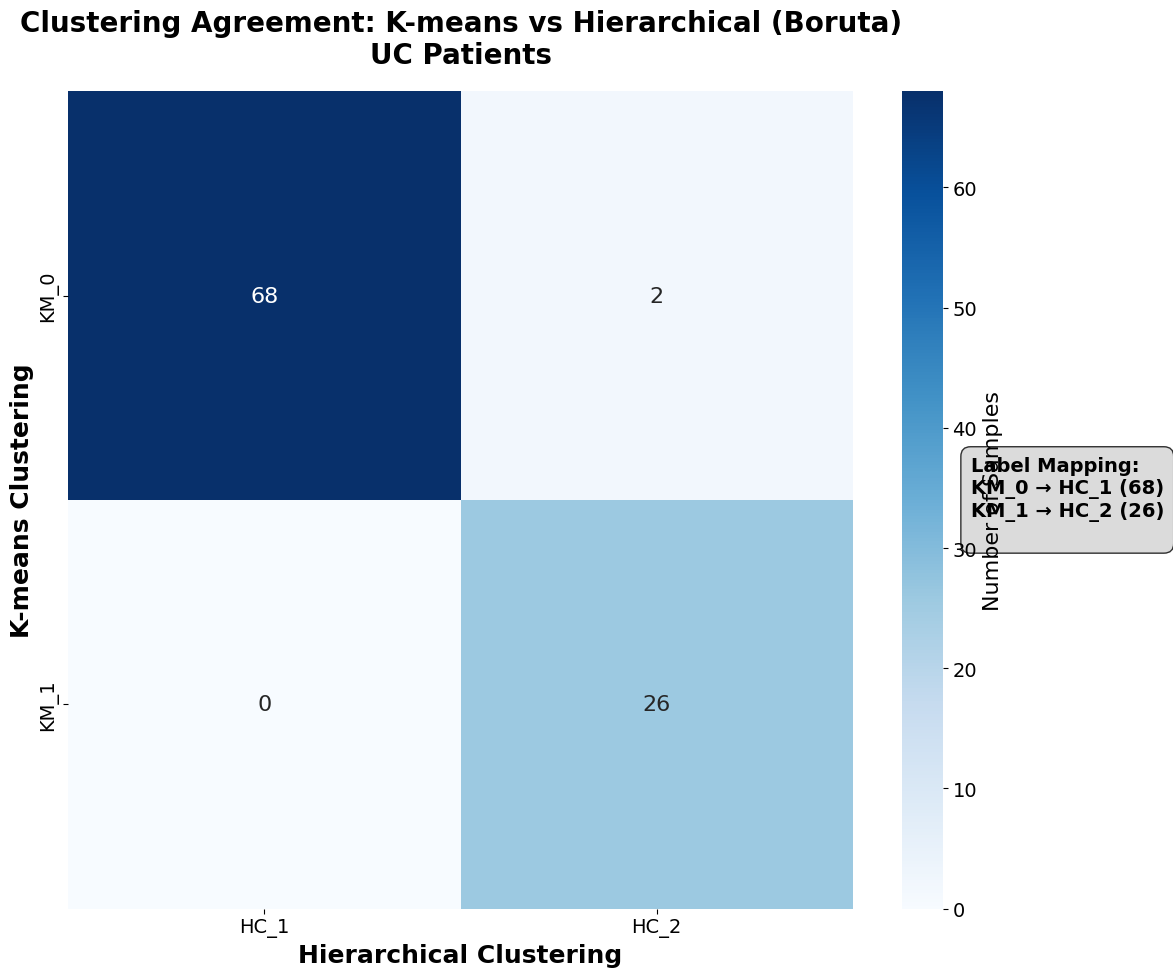

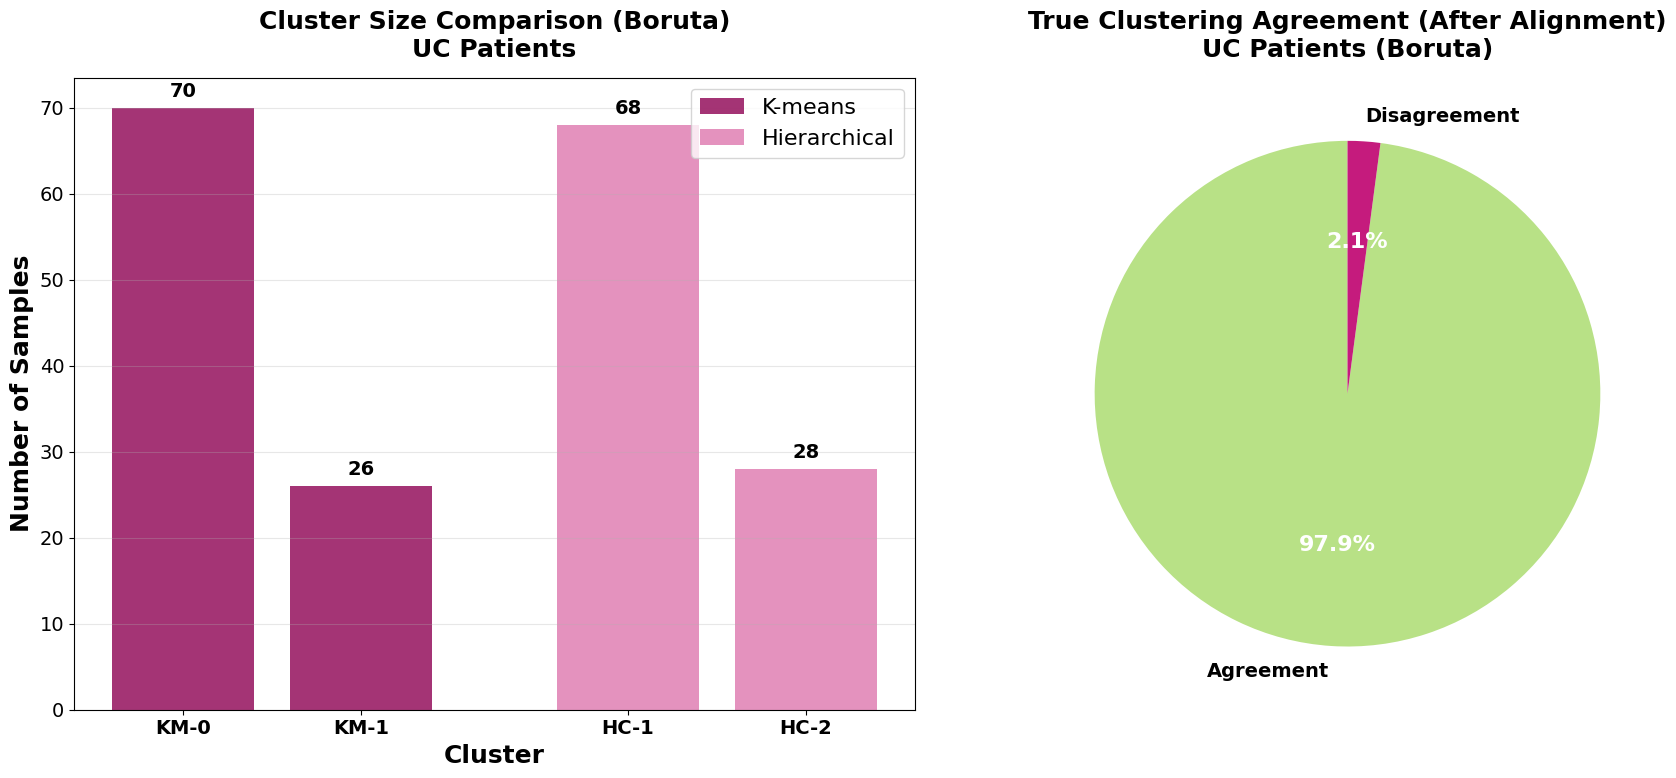

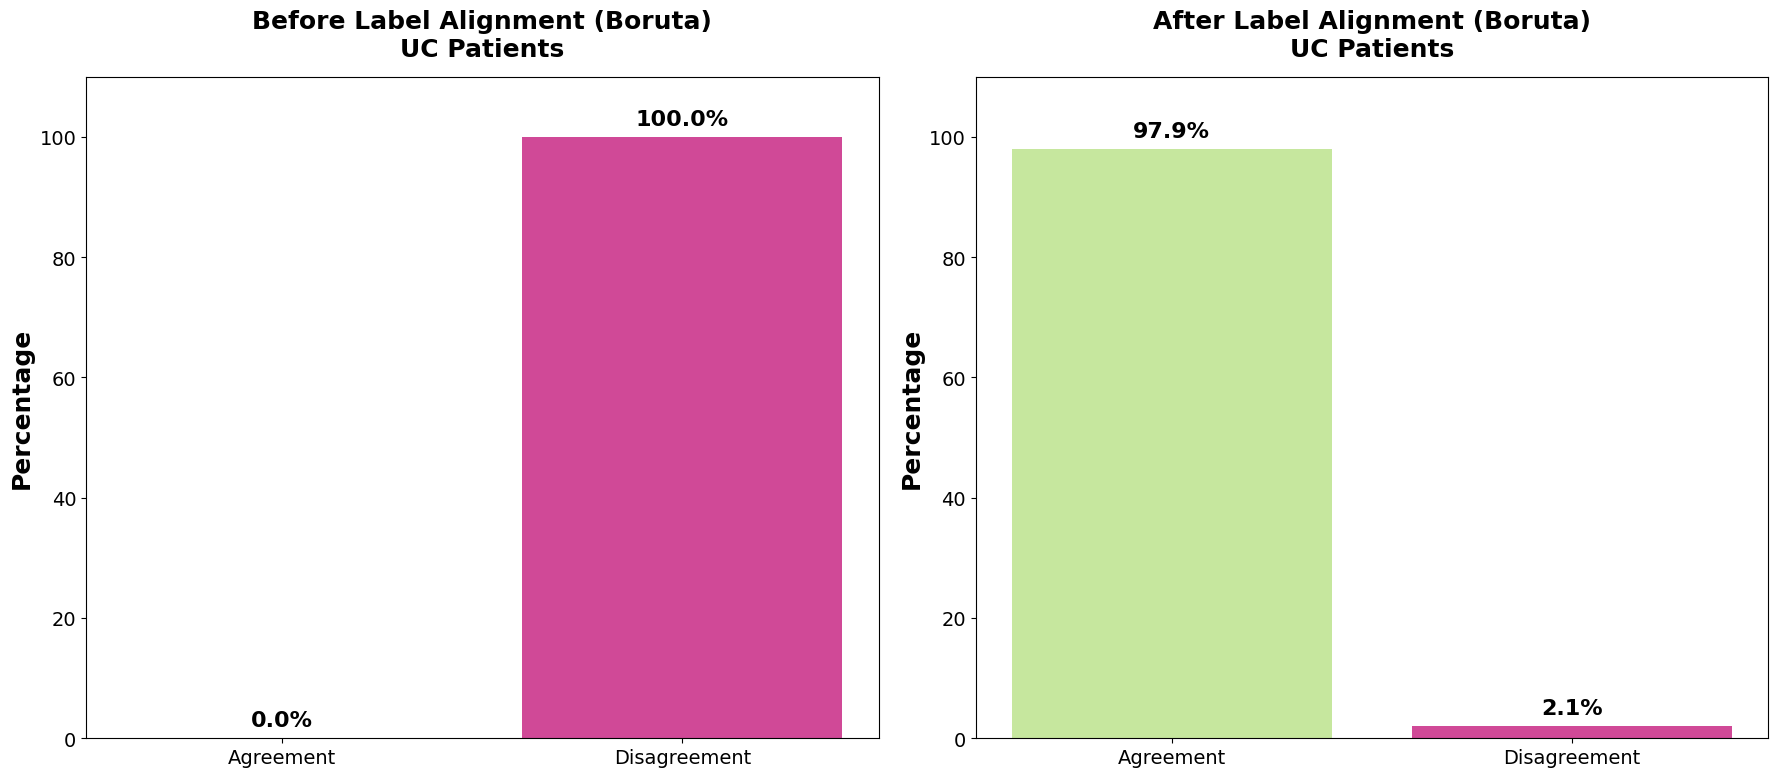


--------------------------------------------------
SAMPLE-LEVEL DISAGREEMENT ANALYSIS (AFTER ALIGNMENT)
--------------------------------------------------
Samples with TRUE disagreement: 2/96 (2.1%)

Samples with TRUE clustering disagreement:
  Sample  KMeans_Cluster  Hierarchical_Cluster  KMeans_Aligned
HSM5MD3Y               0                     2               1
HSMA33OZ               0                     2               1

True disagreement analysis saved to: boruta_data/UC_clustering_true_disagreements.tsv

SUMMARY REPORT: UC CLUSTERING AGREEMENT (BORUTA)
Samples analyzed: 96
K-means clusters: 2
Hierarchical clusters: 2

Label Mapping:
  K-means 0 → Hierarchical 1
  K-means 1 → Hierarchical 2

Agreement before alignment: 0.0%
Agreement after optimal alignment: 97.9%
TRUE agreement after alignment: 97.9%
Adjusted Rand Index: 0.9147
Normalized Mutual Information: 0.8572
Fowlkes-Mallows Index: 0.9653

Summary saved to: boruta_data/UC_clustering_agreement_summary_aligned.tsv


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
from sklearn.metrics import confusion_matrix, classification_report
import scipy.stats as stats
from matplotlib.patches import Patch
from scipy.optimize import linear_sum_assignment
from matplotlib.colors import ListedColormap
import matplotlib as mpl

# Custom color palette
CUSTOM_COLORS = ['#8e0152','#c51b7d','#de77ae','#f1b6da','#fde0ef','#e6f5d0','#b8e186','#7fbc41','#4d9221','#276419']

# Set global font sizes
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 20
})

def load_clustering_results(dataset_prefix='CD'):
    """Load clustering results from both methods"""
    
    # File paths based on your code structure
    kmeans_file = f'processing_data/{dataset_prefix}_kmeans_2_clustered_data.tsv'
    hc_file = f'processing_data/{dataset_prefix}_hierarchical_clustered_data.tsv'
    
    try:
        kmeans_df = pd.read_csv(kmeans_file, sep='\t')
        print(f"Loaded K-means results: {kmeans_df.shape}")
    except FileNotFoundError:
        print(f"Error: {kmeans_file} not found")
        return None, None
    
    try:
        hc_df = pd.read_csv(hc_file, sep='\t')
        print(f"Loaded Hierarchical clustering results: {hc_df.shape}")
    except FileNotFoundError:
        print(f"Error: {hc_file} not found")
        return None, None
    
    return kmeans_df, hc_df

def find_optimal_label_mapping(labels1, labels2):
    """Find optimal mapping between two sets of cluster labels using Hungarian algorithm"""
    
    # Get unique labels
    unique1 = sorted(np.unique(labels1))
    unique2 = sorted(np.unique(labels2))
    
    print(f"Debug - Unique labels in method 1: {unique1}")
    print(f"Debug - Unique labels in method 2: {unique2}")
    
    # Create confusion matrix - simple approach
    cm = np.zeros((len(unique1), len(unique2)))
    for i, l1 in enumerate(unique1):
        for j, l2 in enumerate(unique2):
            cm[i, j] = np.sum((labels1 == l1) & (labels2 == l2))
    
    print(f"Debug - Confusion matrix shape: {cm.shape}")
    print(f"Debug - Confusion matrix:\n{cm}")
    
    # Handle case where number of clusters differs
    if len(unique1) != len(unique2):
        # Pad the smaller dimension with zeros to make it square
        max_n = max(len(unique1), len(unique2))
        padded_cm = np.zeros((max_n, max_n))
        padded_cm[:len(unique1), :len(unique2)] = cm
        cm_for_assignment = padded_cm
    else:
        cm_for_assignment = cm
    
    # Hungarian algorithm to find optimal assignment
    # We want to maximize agreement, so using negative of confusion matrix
    row_ind, col_ind = linear_sum_assignment(-cm_for_assignment)
    
    print(f"Debug - Hungarian algorithm indices: rows={row_ind}, cols={col_ind}")
    
    # mapping dictionary
    mapping = {}
    for i, j in zip(row_ind, col_ind):
        if i < len(unique1) and j < len(unique2):
            mapping[unique1[i]] = unique2[j]
            print(f"Debug - Mapping {unique1[i]} → {unique2[j]} (count: {cm[i,j]})")
    
    # agreement score after optimal mapping
    mapped_labels1 = np.array([mapping.get(label, label) for label in labels1])
    agreement_score = np.sum(mapped_labels1 == labels2) / len(labels1)
    
    return mapping, agreement_score, cm

def align_cluster_labels(kmeans_labels, hc_labels):
    """Align cluster labels to maximize agreement"""
    
    # Find optimal mapping from kmeans to hierarchical
    mapping, agreement_score, cm = find_optimal_label_mapping(kmeans_labels, hc_labels)
    
    # mapping to kmeans labels
    aligned_kmeans = np.array([mapping.get(label, label) for label in kmeans_labels])
    
    return aligned_kmeans, mapping, agreement_score

def analyze_clustering_agreement(kmeans_df, hc_df, dataset_prefix='CD'):
    """Comprehensive agreement analysis between clustering methods with label alignment"""
    
    print(f"\n{'='*60}")
    print(f"CLUSTERING AGREEMENT ANALYSIS FOR {dataset_prefix} PATIENTS (BORUTA)")
    print(f"{'='*60}")
    
    # Ensuring we're comparing the same samples
    common_samples = set(kmeans_df['Sample']).intersection(set(hc_df['Sample']))
    
    if len(common_samples) == 0:
        print("No common samples found between clustering results!")
        return None
    
    print(f"Analyzing agreement for {len(common_samples)} common samples")
    
    # Filters to common samples and sort by Sample ID for alignment
    kmeans_common = kmeans_df[kmeans_df['Sample'].isin(common_samples)].sort_values('Sample').reset_index(drop=True)
    hc_common = hc_df[hc_df['Sample'].isin(common_samples)].sort_values('Sample').reset_index(drop=True)
    
    # Extract cluster labels
    kmeans_labels_original = kmeans_common['KMeans_Cluster'].values
    hc_labels = hc_common['Hierarchical_Cluster'].values
    sample_ids = kmeans_common['Sample'].values
    
    # Basic cluster information
    print(f"\nOriginal K-means clusters: {sorted(np.unique(kmeans_labels_original))}")
    print(f"Hierarchical clusters: {sorted(np.unique(hc_labels))}")
    print(f"Number of K-means clusters: {len(np.unique(kmeans_labels_original))}")
    print(f"Number of Hierarchical clusters: {len(np.unique(hc_labels))}")
    
    # # Additional debugging for UC with 3 clusters
    # if dataset_prefix == 'UC' and len(np.unique(hc_labels)) < 3:
    #     print("\nDEBUG: Expected 3 hierarchical clusters for UC but found fewer.")
    #     print("Checking original data before filtering...")
    #     hc_all_clusters = sorted(hc_df['Hierarchical_Cluster'].unique())
    #     print(f"All hierarchical clusters in original file: {hc_all_clusters}")
    #     for cluster in hc_all_clusters:
    #         n_samples = len(hc_df[hc_df['Hierarchical_Cluster'] == cluster])
    #         n_common = len(hc_df[(hc_df['Hierarchical_Cluster'] == cluster) & (hc_df['Sample'].isin(common_samples))])
    #         print(f"  Cluster {cluster}: {n_samples} total samples, {n_common} in common set")
    
    # --- Label Alignment ---
    print(f"\n{'-'*50}")
    print("CLUSTER LABEL ALIGNMENT")
    print(f"{'-'*50}")
    
    kmeans_labels, label_mapping, alignment_score = align_cluster_labels(kmeans_labels_original, hc_labels)
    
    print(f"Optimal label mapping (K-means → Hierarchical):")
    for k, v in label_mapping.items():
        n_samples = np.sum(kmeans_labels_original == k)
        print(f"  K-means Cluster {k} → Hierarchical Cluster {v} ({n_samples} samples)")
    
    # Calculate agreement before alignment
    before_alignment_agreement = np.sum(kmeans_labels_original == hc_labels) / len(kmeans_labels_original)
    print(f"\nAgreement before alignment: {before_alignment_agreement*100:.1f}%")
    print(f"Agreement after optimal alignment: {alignment_score*100:.1f}%")
    
    # --- Agreement Metrics (these don't change with label alignment) ---
    print(f"\n{'-'*50}")
    print("CLUSTERING AGREEMENT METRICS")
    print(f"{'-'*50}")
    
    # These metrics are invariant to label permutations
    ari = adjusted_rand_score(kmeans_labels_original, hc_labels)
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"  Interpretation: {interpret_ari(ari)}")
    
    nmi = normalized_mutual_info_score(kmeans_labels_original, hc_labels)
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
    print(f"  Interpretation: {interpret_nmi(nmi)}")
    
    fmi = fowlkes_mallows_score(kmeans_labels_original, hc_labels)
    print(f"Fowlkes-Mallows Index (FMI): {fmi:.4f}")
    print(f"  Interpretation: {interpret_fmi(fmi)}")
    
    # --- Confusion Matrix Analysis ---
    print(f"\n{'-'*50}")
    print("CONFUSION MATRIX ANALYSIS")
    print(f"{'-'*50}")
    
    # Create confusion matrix with original labels
    kmeans_clusters = sorted(np.unique(kmeans_labels_original))
    hc_clusters = sorted(np.unique(hc_labels))
    
    # Create confusion matrix properly handling different label sets
    all_labels = sorted(set(kmeans_clusters) | set(hc_clusters))
    cm_full = confusion_matrix(kmeans_labels_original, hc_labels, labels=all_labels)
    
    # Extract the relevant part of the confusion matrix
    km_indices = [all_labels.index(k) for k in kmeans_clusters]
    hc_indices = [all_labels.index(h) for h in hc_clusters]
    cm = cm_full[np.ix_(km_indices, hc_indices)]
    
    print("Confusion Matrix (K-means vs Hierarchical):")
    print("Rows = K-means clusters, Columns = Hierarchical clusters")
    
    # Create DataFrame for confusion matrix
    cm_df = pd.DataFrame(cm, 
                        index=[f'KM_{i}' for i in kmeans_clusters],
                        columns=[f'HC_{i}' for i in hc_clusters])
    print(cm_df)
    
    # Additional analysis for different numbers of clusters
    if len(kmeans_clusters) != len(hc_clusters):
        print(f"\n{'-'*50}")
        print("CLUSTER SPLIT ANALYSIS")
        print(f"{'-'*50}")
        print(f"K-means has {len(kmeans_clusters)} clusters, Hierarchical has {len(hc_clusters)} clusters")
        
        if len(kmeans_clusters) < len(hc_clusters):
            print("\nHow K-means clusters split across Hierarchical clusters:")
            for i, km_cluster in enumerate(kmeans_clusters):
                row_data = cm[i, :]
                total = np.sum(row_data)
                print(f"\nK-means Cluster {km_cluster} ({total} samples) splits into:")
                for j, hc_cluster in enumerate(hc_clusters):
                    count = row_data[j]
                    if count > 0:
                        print(f"  → HC Cluster {hc_cluster}: {count} samples ({count/total*100:.1f}%)")
        else:
            print("\nHow Hierarchical clusters map to K-means clusters:")
            for j, hc_cluster in enumerate(hc_clusters):
                col_data = cm[:, j]
                total = np.sum(col_data)
                print(f"\nHierarchical Cluster {hc_cluster} ({total} samples) maps to:")
                for i, km_cluster in enumerate(kmeans_clusters):
                    count = col_data[i]
                    if count > 0:
                        print(f"  → KM Cluster {km_cluster}: {count} samples ({count/total*100:.1f}%)")
    
    # --- Visualizations ---
    create_agreement_visualizations(kmeans_labels_original, hc_labels, kmeans_labels, 
                                  sample_ids, kmeans_clusters, hc_clusters, 
                                  cm_df, label_mapping, dataset_prefix)
    
    # --- Sample-level Analysis (AFTER ALIGNMENT) ---
    print(f"\n{'-'*50}")
    print("SAMPLE-LEVEL DISAGREEMENT ANALYSIS (AFTER ALIGNMENT)")
    print(f"{'-'*50}")
    
    # Identify samples with TRUE disagreement after alignment
    true_disagreement_mask = kmeans_labels != hc_labels
    disagreeing_samples = sample_ids[true_disagreement_mask]
    
    if len(disagreeing_samples) > 0:
        print(f"Samples with TRUE disagreement: {len(disagreeing_samples)}/{len(sample_ids)} ({len(disagreeing_samples)/len(sample_ids)*100:.1f}%)")
        
        # Create disagreement analysis DataFrame
        disagreement_df = pd.DataFrame({
            'Sample': sample_ids[true_disagreement_mask],
            'KMeans_Cluster': kmeans_labels_original[true_disagreement_mask],
            'Hierarchical_Cluster': hc_labels[true_disagreement_mask],
            'KMeans_Aligned': kmeans_labels[true_disagreement_mask]
        })
        
        print("\nSamples with TRUE clustering disagreement:")
        print(disagreement_df.to_string(index=False))
        
        # Save disagreement analysis
        disagreement_df.to_csv(f'boruta_data/{dataset_prefix}_clustering_true_disagreements.tsv', sep='\t', index=False)
        print(f"\nTrue disagreement analysis saved to: boruta_data/{dataset_prefix}_clustering_true_disagreements.tsv")
    else:
        print("Perfect agreement after label alignment! All samples assigned to corresponding clusters.")
    
    # --- Summary Results ---
    before_alignment_percentage = np.sum(kmeans_labels_original == hc_labels) / len(kmeans_labels_original) * 100
    
    results_summary = {
        'dataset': dataset_prefix,
        'n_samples': len(sample_ids),
        'n_kmeans_clusters': len(np.unique(kmeans_labels_original)),
        'n_hc_clusters': len(np.unique(hc_labels)),
        'adjusted_rand_index': ari,
        'normalized_mutual_info': nmi,
        'fowlkes_mallows_index': fmi,
        'label_mapping': label_mapping,
        'agreement_before_alignment': before_alignment_percentage,
        'alignment_agreement_percentage': alignment_score * 100,
        'true_agreement_percentage': (len(sample_ids) - len(disagreeing_samples)) / len(sample_ids) * 100,
        'true_disagreeing_samples': len(disagreeing_samples),
        'confusion_matrix': cm_df
    }
    
    return results_summary

def interpret_ari(ari):
    """Interpret Adjusted Rand Index values"""
    if ari >= 0.9:
        return "Excellent agreement"
    elif ari >= 0.7:
        return "Good agreement"
    elif ari >= 0.5:
        return "Moderate agreement"
    elif ari >= 0.3:
        return "Fair agreement"
    elif ari >= 0.1:
        return "Poor agreement"
    else:
        return "Very poor agreement"

def interpret_nmi(nmi):
    """Interpret Normalized Mutual Information values"""
    if nmi >= 0.9:
        return "Excellent information sharing"
    elif nmi >= 0.7:
        return "Good information sharing"
    elif nmi >= 0.5:
        return "Moderate information sharing"
    elif nmi >= 0.3:
        return "Fair information sharing"
    else:
        return "Poor information sharing"

def interpret_fmi(fmi):
    """Interpret Fowlkes-Mallows Index values"""
    if fmi >= 0.9:
        return "Excellent similarity"
    elif fmi >= 0.7:
        return "Good similarity"
    elif fmi >= 0.5:
        return "Moderate similarity"
    elif fmi >= 0.3:
        return "Fair similarity"
    else:
        return "Poor similarity"

def create_agreement_visualizations(kmeans_labels_original, hc_labels, kmeans_labels_aligned,
                                  sample_ids, kmeans_clusters, hc_clusters, 
                                  cm_df, label_mapping, dataset_prefix):
    """Create comprehensive visualizations for clustering agreement with custom colors and larger fonts"""
    
    custom_cmap = ListedColormap(CUSTOM_COLORS)
    
    # 1. Confusion Matrix Heatmap
    if len(kmeans_clusters) != len(hc_clusters):
        fig_width = 10 + len(hc_clusters) * 1.5
        fig_height = 8 + len(kmeans_clusters) * 1.5
        plt.figure(figsize=(fig_width, fig_height))
    else:
        plt.figure(figsize=(12, 10))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', 
                cbar_kws={'label': 'Number of Samples'},
                annot_kws={'size': 16})
    plt.title(f'Clustering Agreement: K-means vs Hierarchical (Boruta)\n{dataset_prefix} Patients', 
              fontsize=20, pad=20, fontweight='bold')
    plt.xlabel('Hierarchical Clustering', fontsize=18, fontweight='bold')
    plt.ylabel('K-means Clustering', fontsize=18, fontweight='bold')
    mapping_text = "Label Mapping:\n"
    for k, v in label_mapping.items():
        n_samples = int(cm_df.loc[f'KM_{k}', f'HC_{v}']) if f'HC_{v}' in cm_df.columns else 0
        mapping_text += f"KM_{k} → HC_{v} ({n_samples})\n"
    plt.text(1.15, 0.5, mapping_text, transform=plt.gca().transAxes,
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8),
             verticalalignment='center', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'boruta_data/{dataset_prefix}_clustering_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Agreement Pattern Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    kmeans_counts = pd.Series(kmeans_labels_original).value_counts().sort_index()
    hc_counts = pd.Series(hc_labels).value_counts().sort_index()
    all_km_clusters = sorted(np.unique(kmeans_labels_original))
    all_hc_clusters = sorted(np.unique(hc_labels))
    km_x_pos = np.arange(len(all_km_clusters))
    hc_x_pos = np.arange(len(all_hc_clusters)) + len(all_km_clusters) + 0.5
    
    # Plot K-means clusters with custom colors
    km_bars = ax1.bar(km_x_pos, [kmeans_counts[c] for c in all_km_clusters], 
                      width=0.8, label='K-means', alpha=0.8, color=CUSTOM_COLORS[0])
    hc_bars = ax1.bar(hc_x_pos, [hc_counts[c] for c in all_hc_clusters], 
                      width=0.8, label='Hierarchical', alpha=0.8, color=CUSTOM_COLORS[2])
    for bars, clusters in [(km_bars, all_km_clusters), (hc_bars, all_hc_clusters)]:
        for bar, cluster in zip(bars, clusters):
            height = bar.get_height()
            ax1.annotate(f'{int(height)}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 5),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=14, fontweight='bold')
    all_x_pos = list(km_x_pos) + list(hc_x_pos)
    all_labels = [f'KM-{c}' for c in all_km_clusters] + [f'HC-{c}' for c in all_hc_clusters]
    ax1.set_xticks(all_x_pos)
    ax1.set_xticklabels(all_labels, fontsize=14, fontweight='bold')
    
    ax1.set_xlabel('Cluster', fontsize=18, fontweight='bold')
    ax1.set_ylabel('Number of Samples', fontsize=18, fontweight='bold')
    ax1.set_title(f'Cluster Size Comparison (Boruta)\n{dataset_prefix} Patients', fontsize=18, fontweight='bold', pad=15)
    ax1.legend(fontsize=16)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.tick_params(axis='y', labelsize=14)
    
    # Agreement/Disagreement pie chart with custom colors
    true_agreement_count = np.sum(kmeans_labels_aligned == hc_labels)
    true_disagreement_count = len(kmeans_labels_aligned) - true_agreement_count
    
    pie_colors = [CUSTOM_COLORS[6], CUSTOM_COLORS[1]]  # Green and pink from palette
    wedges, texts, autotexts = ax2.pie([true_agreement_count, true_disagreement_count], 
                                      labels=['Agreement', 'Disagreement'],
                                      colors=pie_colors,
                                      autopct='%1.1f%%',
                                      startangle=90,
                                      textprops={'fontsize': 14, 'fontweight': 'bold'})
    
    # Make percentage text larger and bold
    for autotext in autotexts:
        autotext.set_fontsize(16)
        autotext.set_fontweight('bold')
        autotext.set_color('white')
    
    ax2.set_title(f'True Clustering Agreement (After Alignment)\n{dataset_prefix} Patients (Boruta)',
                  fontsize=18, fontweight='bold', pad=15)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Before/After alignment comparison with custom colors
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Before alignment
    before_agreement = np.sum(kmeans_labels_original == hc_labels) / len(kmeans_labels_original) * 100
    bars1 = ax1.bar(['Agreement', 'Disagreement'], 
                    [before_agreement, 100-before_agreement],
                    color=[CUSTOM_COLORS[6], CUSTOM_COLORS[1]], alpha=0.8)
    ax1.set_ylabel('Percentage', fontsize=18, fontweight='bold')
    ax1.set_title(f'Before Label Alignment (Boruta)\n{dataset_prefix} Patients', fontsize=18, fontweight='bold', pad=15)
    ax1.set_ylim(0, 110)
    ax1.tick_params(axis='both', labelsize=14)
    
    for i, (bar, v) in enumerate(zip(bars1, [before_agreement, 100-before_agreement])):
        ax1.text(bar.get_x() + bar.get_width()/2, v + 2, f'{v:.1f}%', 
                ha='center', fontsize=16, fontweight='bold')
    
    # After alignment
    after_agreement = np.sum(kmeans_labels_aligned == hc_labels) / len(kmeans_labels_aligned) * 100
    bars2 = ax2.bar(['Agreement', 'Disagreement'], 
                    [after_agreement, 100-after_agreement],
                    color=[CUSTOM_COLORS[6], CUSTOM_COLORS[1]], alpha=0.8)
    ax2.set_ylabel('Percentage', fontsize=18, fontweight='bold')
    ax2.set_title(f'After Label Alignment (Boruta)\n{dataset_prefix} Patients', fontsize=18, fontweight='bold', pad=15)
    ax2.set_ylim(0, 110)
    ax2.tick_params(axis='both', labelsize=14)
    
    for i, (bar, v) in enumerate(zip(bars2, [after_agreement, 100-after_agreement])):
        ax2.text(bar.get_x() + bar.get_width()/2, v + 2, f'{v:.1f}%', 
                ha='center', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def run_comprehensive_analysis(dataset_prefix='CD'):
    """Run the complete clustering agreement analysis with label alignment"""
    
    print(f"Starting clustering agreement analysis for {dataset_prefix} patients (Boruta features)...")
    
    # Load data
    kmeans_df, hc_df = load_clustering_results(dataset_prefix)
    
    if kmeans_df is None or hc_df is None:
        print("Could not load clustering results. Please check file paths.")
        return None
    
    # Run agreement analysis
    results = analyze_clustering_agreement(kmeans_df, hc_df, dataset_prefix)
    
    if results is None:
        print("Agreement analysis failed.")
        return None
    
    # Create summary report
    print(f"\n{'='*60}")
    print(f"SUMMARY REPORT: {dataset_prefix} CLUSTERING AGREEMENT (BORUTA)")
    print(f"{'='*60}")
    print(f"Samples analyzed: {results['n_samples']}")
    print(f"K-means clusters: {results['n_kmeans_clusters']}")
    print(f"Hierarchical clusters: {results['n_hc_clusters']}")
    print(f"\nLabel Mapping:")
    for k, v in results['label_mapping'].items():
        print(f"  K-means {k} → Hierarchical {v}")
    
    if results['n_kmeans_clusters'] != results['n_hc_clusters']:
        print(f"\nNote: K-means has {results['n_kmeans_clusters']} clusters while Hierarchical has {results['n_hc_clusters']} clusters")
        print("The mapping shows the best alignment, but perfect 1:1 correspondence is not possible.")
    
    print(f"\nAgreement before alignment: {results['agreement_before_alignment']:.1f}%")
    print(f"Agreement after optimal alignment: {results['alignment_agreement_percentage']:.1f}%")
    print(f"TRUE agreement after alignment: {results['true_agreement_percentage']:.1f}%")
    print(f"Adjusted Rand Index: {results['adjusted_rand_index']:.4f}")
    print(f"Normalized Mutual Information: {results['normalized_mutual_info']:.4f}")
    print(f"Fowlkes-Mallows Index: {results['fowlkes_mallows_index']:.4f}")
    
    # Save summary to file
    summary_df = pd.DataFrame([{
        'Dataset': results['dataset'],
        'N_Samples': results['n_samples'],
        'N_KMeans_Clusters': results['n_kmeans_clusters'],
        'N_HC_Clusters': results['n_hc_clusters'],
        'Agreement_Before_Alignment': results['agreement_before_alignment'],
        'Agreement_After_Optimal_Alignment': results['alignment_agreement_percentage'],
        'True_Agreement_After_Alignment': results['true_agreement_percentage'],
        'Adjusted_Rand_Index': results['adjusted_rand_index'],
        'Normalized_Mutual_Info': results['normalized_mutual_info'],
        'Fowlkes_Mallows_Index': results['fowlkes_mallows_index'],
        'True_Disagreeing_Samples': results['true_disagreeing_samples']
    }])
    
    summary_df.to_csv(f'boruta_data/{dataset_prefix}_clustering_agreement_summary_aligned.tsv', sep='\t', index=False)
    print(f"\nSummary saved to: boruta_data/{dataset_prefix}_clustering_agreement_summary_aligned.tsv")
    
    return results

if __name__ == "__main__":
    # Run analysis for CD and UC patients
    cd_results = run_comprehensive_analysis('CD')
    uc_results = run_comprehensive_analysis('UC')